In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import math

init_notebook_mode(connected=True)

data_path = "res/YearPredictionMSD.txt"
result_folder = "results/"

test_set_ratio=0.1

In [2]:
df_data = pd.read_csv(data_path, header=None)
df_data.columns = ['year'] + ['timbre_avg' + str(i) for i in range(1,13)] + ['timbre_cov' + str(i) for i in range(1,79)]
# What is timbre? refer to http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf
df_data.head(10)

,year,timbre_avg1,timbre_avg2,timbre_avg3,timbre_avg4,timbre_avg5,timbre_avg6,timbre_avg7,timbre_avg8,timbre_avg9,...,timbre_cov69,timbre_cov70,timbre_cov71,timbre_cov72,timbre_cov73,timbre_cov74,timbre_cov75,timbre_cov76,timbre_cov77,timbre_cov78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263
6,2001,50.57546,33.17843,50.53517,11.55217,-27.24764,-8.78206,-12.04282,-9.53930,28.61811,...,11.63681,25.44182,134.62382,21.51982,8.17570,35.46251,11.57736,4.50056,-4.62739,1.40192
7,2001,48.26892,8.97526,75.23158,24.04945,-16.02105,-14.09491,8.11871,-1.87566,7.46701,...,18.03989,-58.46192,-65.56438,46.99856,-4.09602,56.37650,-18.29975,-0.30633,3.98364,-3.72556
8,2001,49.75468,33.99581,56.73846,2.89581,-2.92429,-26.44413,1.71392,-0.55644,22.08594,...,18.70812,5.20391,-27.75192,17.22100,-0.85210,-15.67150,-26.36257,5.48708,-9.13495,6.08680
9,2007,45.17809,46.34234,-40.65357,-2.47909,1.21253,-0.65302,-6.95536,-12.20040,17.02512,...,-4.36742,-87.55285,-70.79677,76.57355,-7.71727,3.26926,-298.49845,11.49326,-89.21804,-15.09719


In [3]:
# split up according to dataset description (i.e. 'producer effect' is avoided)
df_train = df_data.loc[:463715,:]
df_test = df_data.loc[463715:,:]

In [4]:
df_data.describe()

,year,timbre_avg1,timbre_avg2,timbre_avg3,timbre_avg4,timbre_avg5,timbre_avg6,timbre_avg7,timbre_avg8,timbre_avg9,...,timbre_cov69,timbre_cov70,timbre_cov71,timbre_cov72,timbre_cov73,timbre_cov74,timbre_cov75,timbre_cov76,timbre_cov77,timbre_cov78
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


E:\Python\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



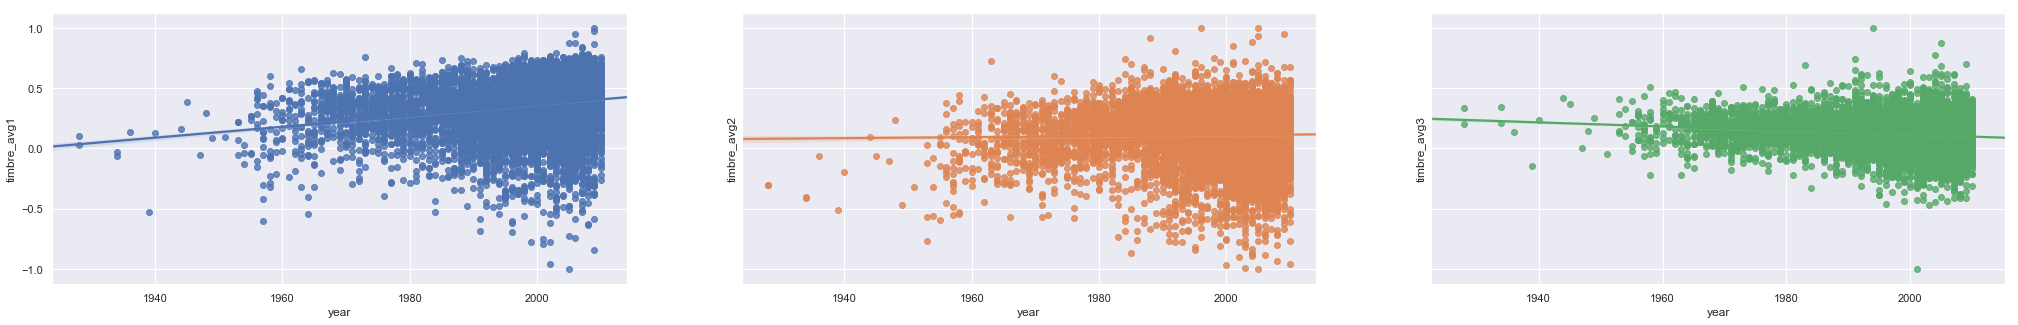

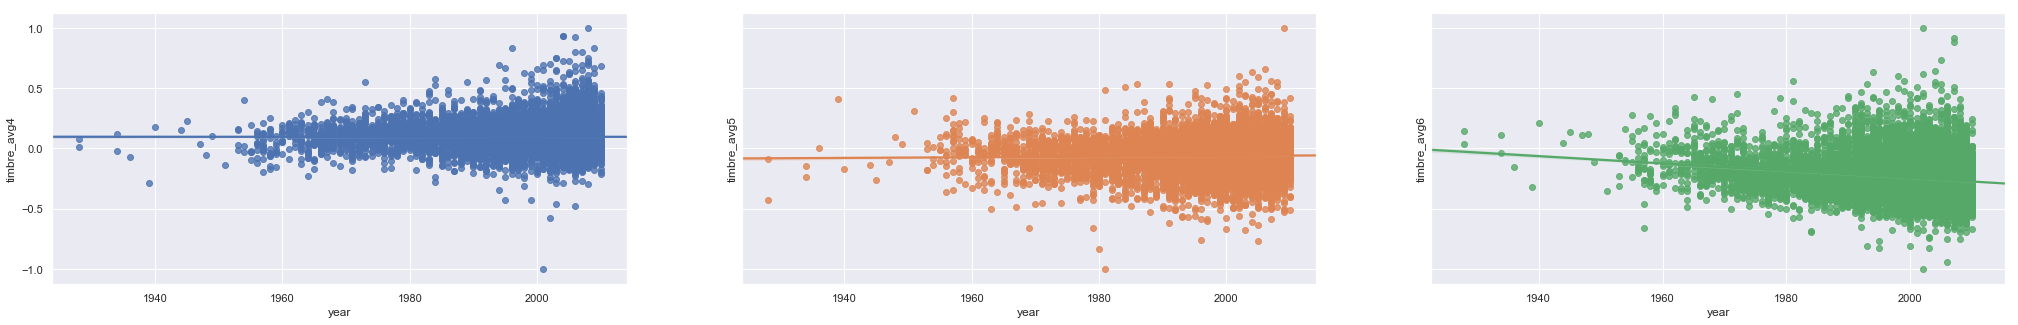

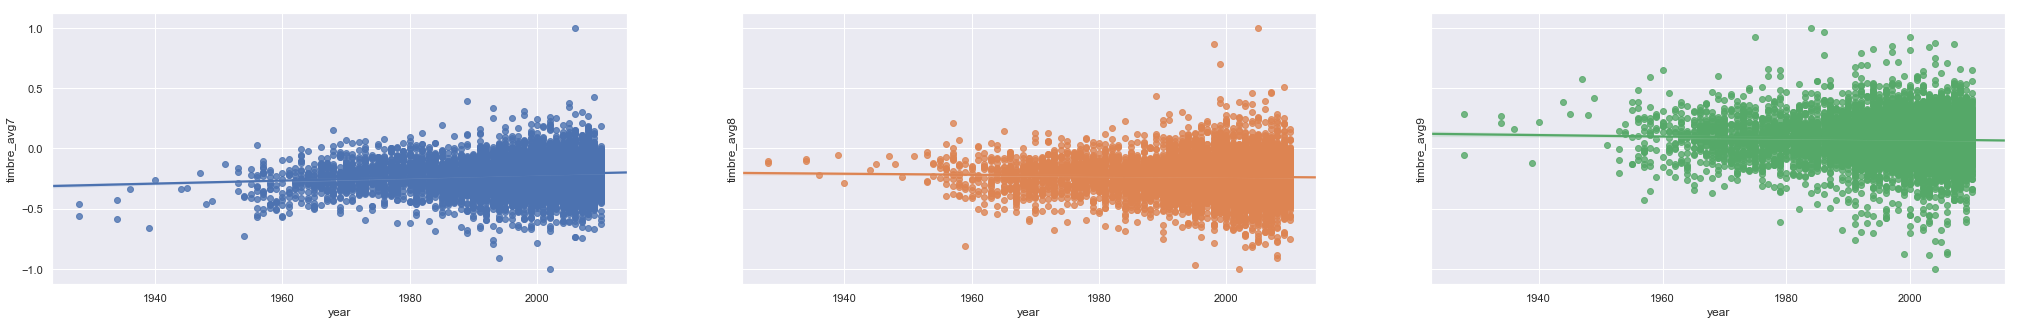

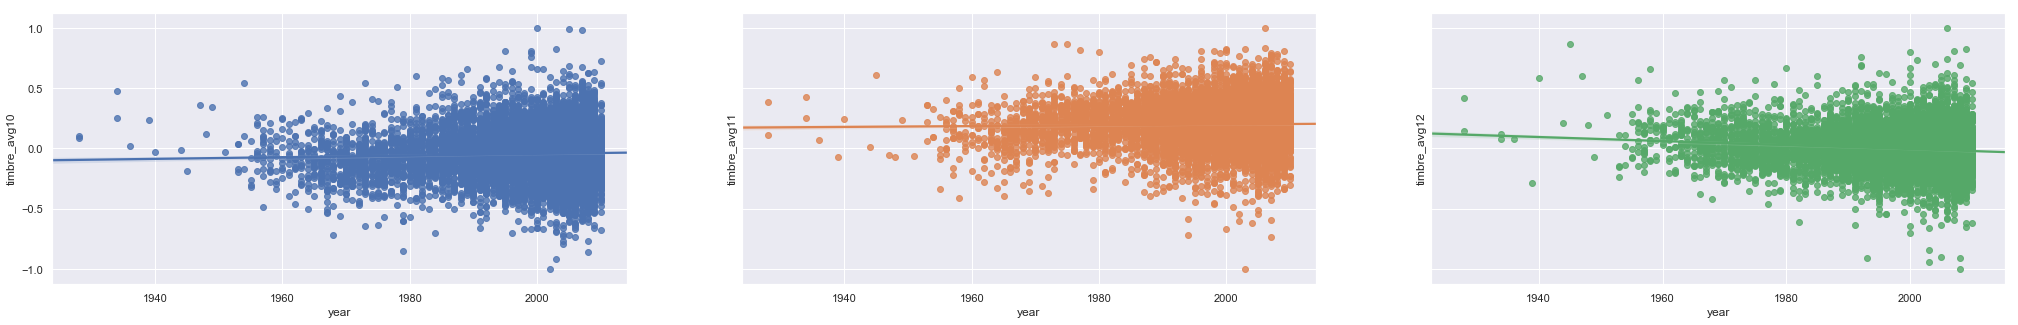

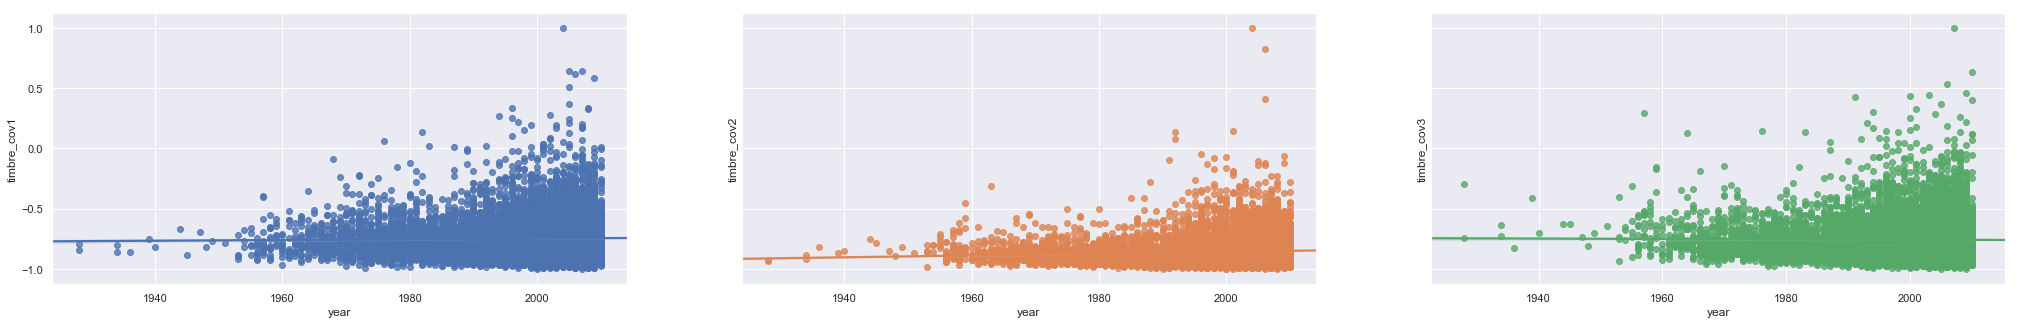

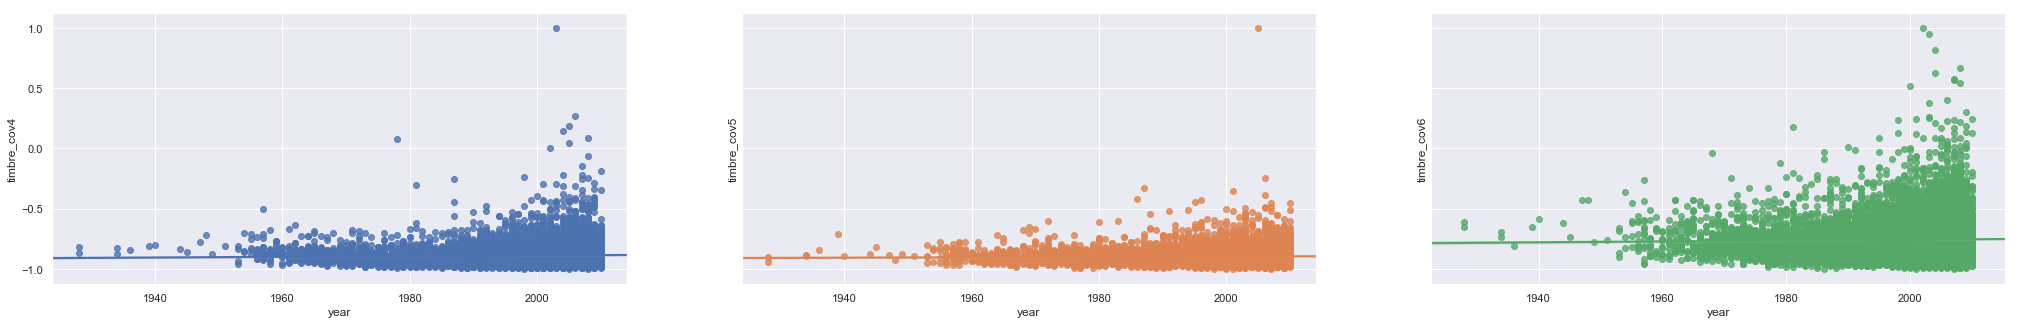

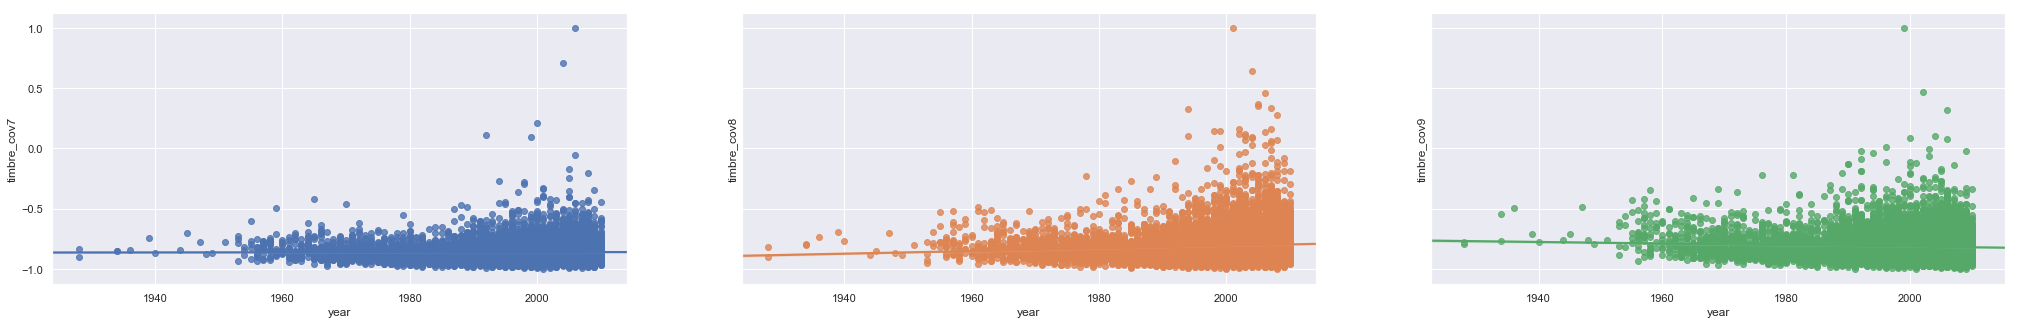

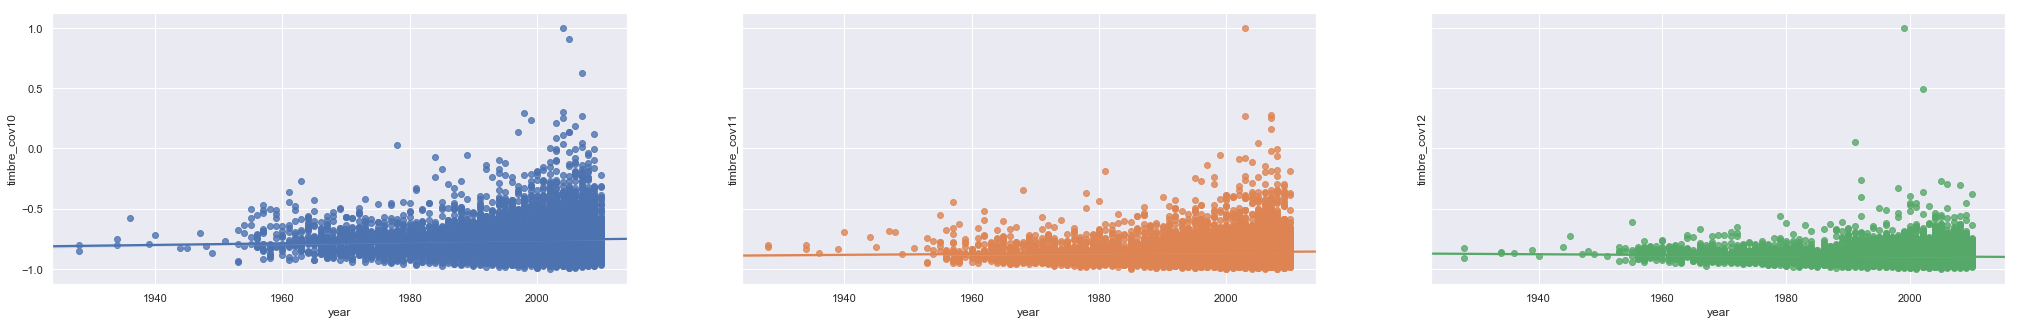

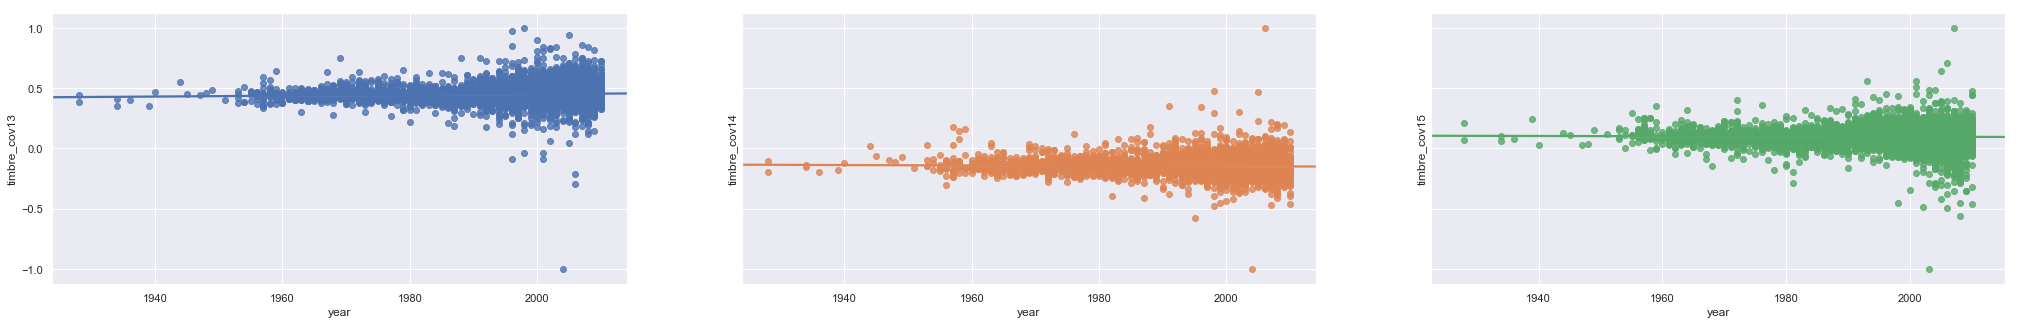

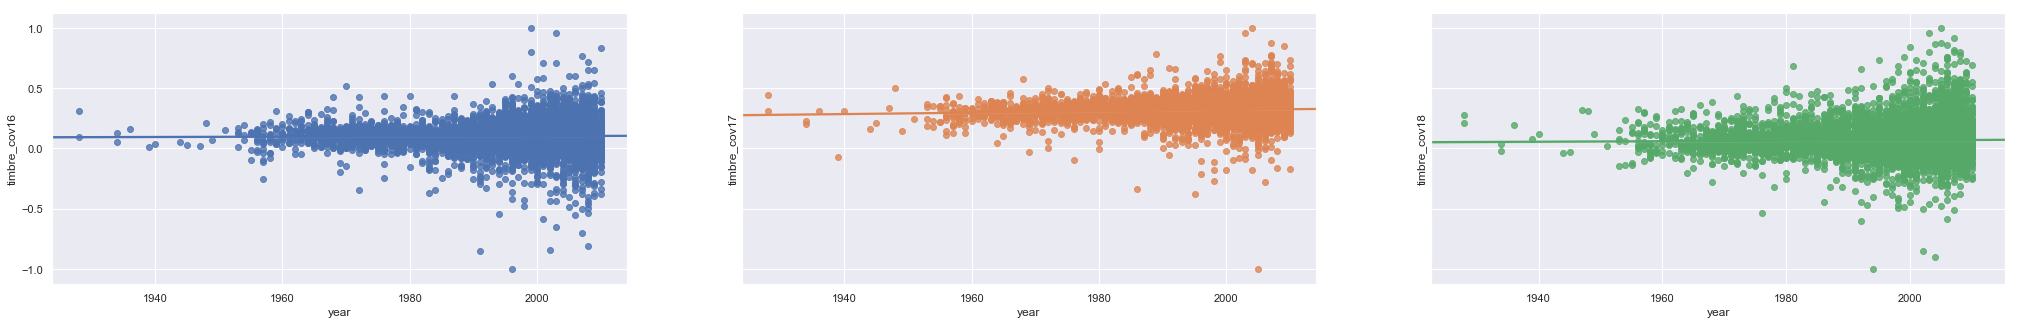

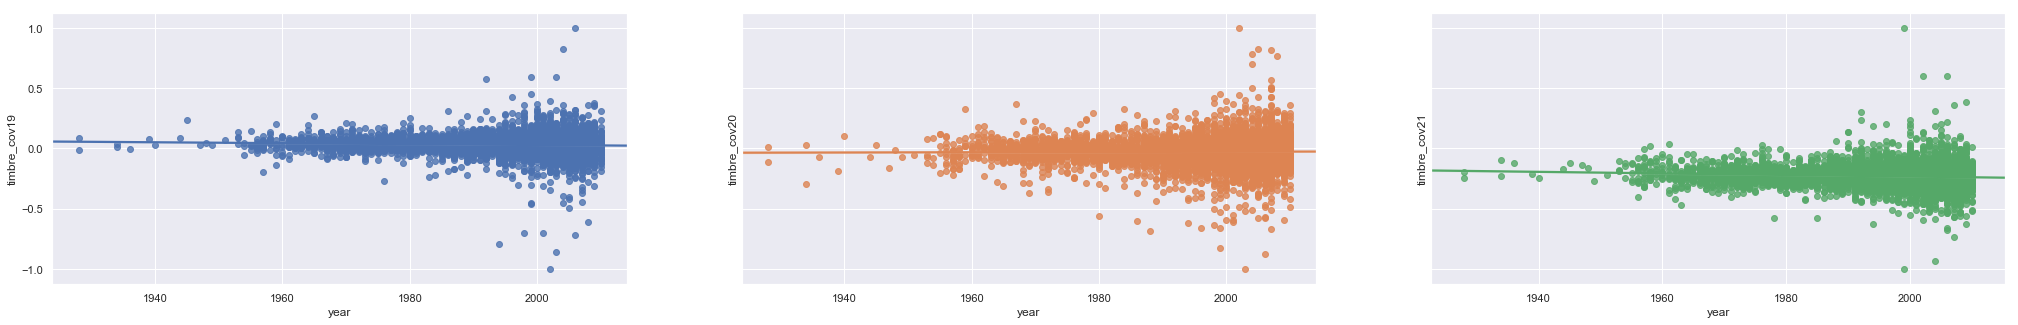

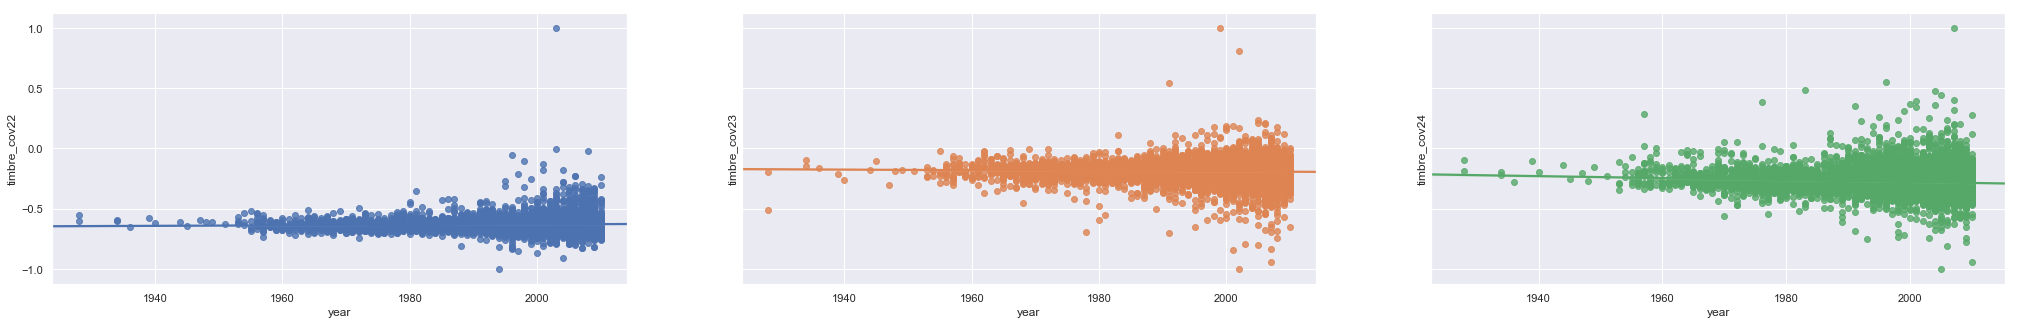

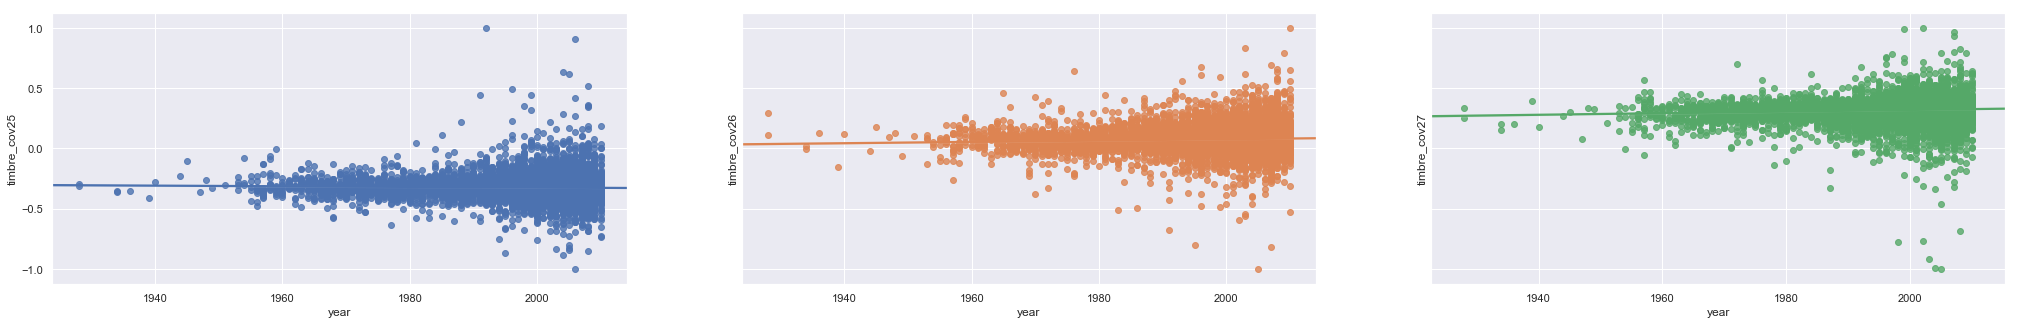

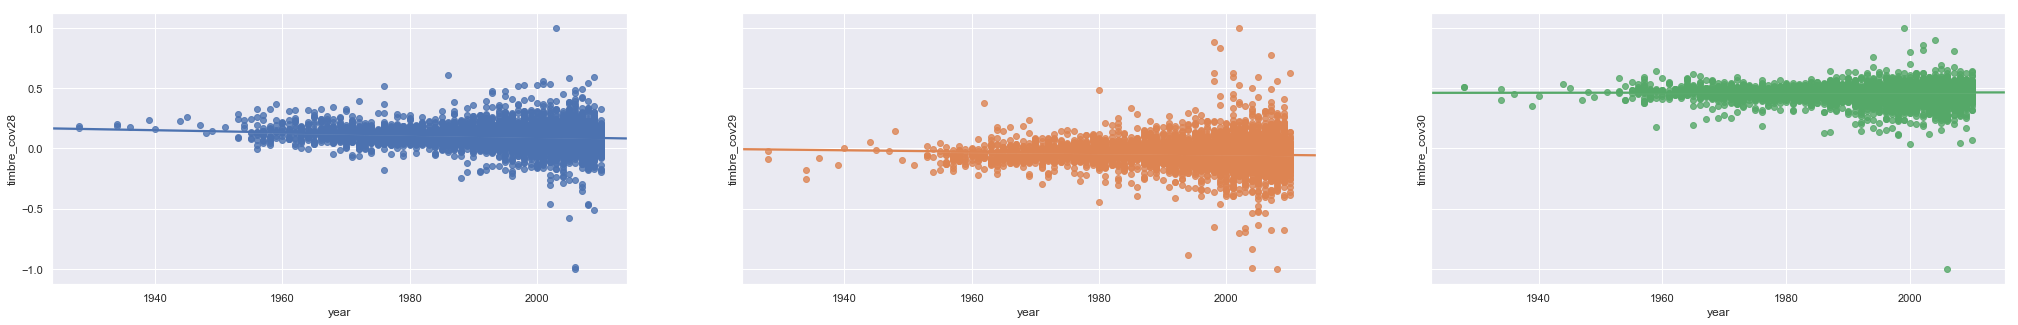

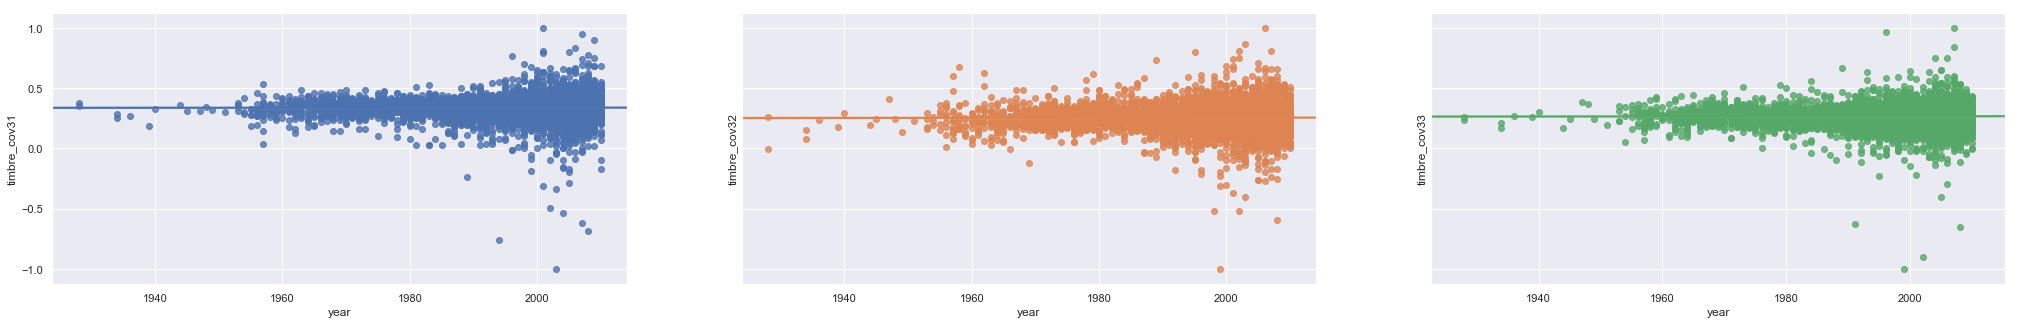

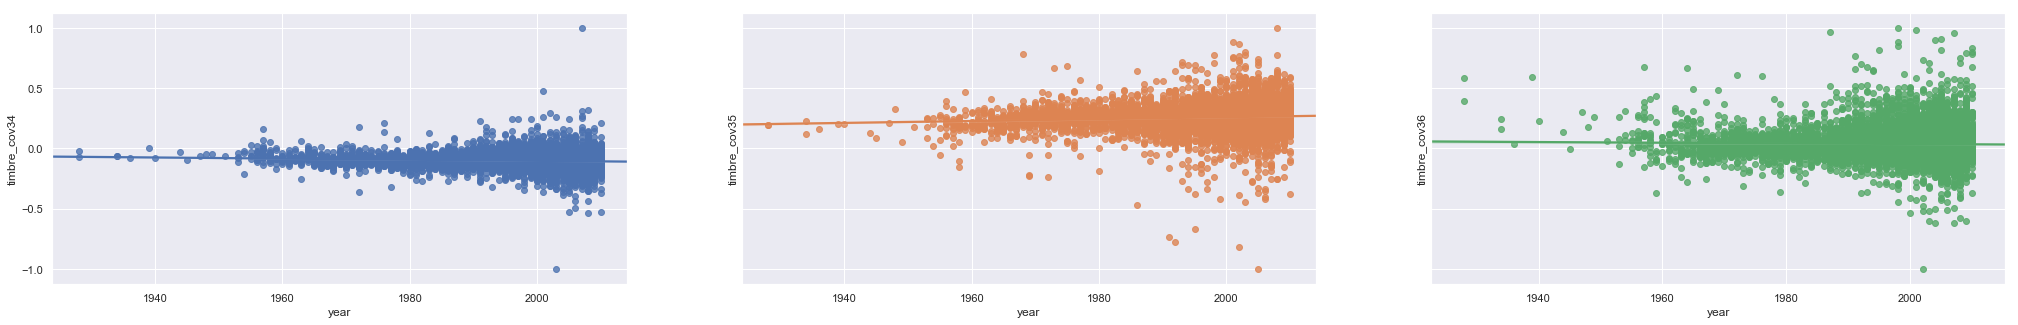

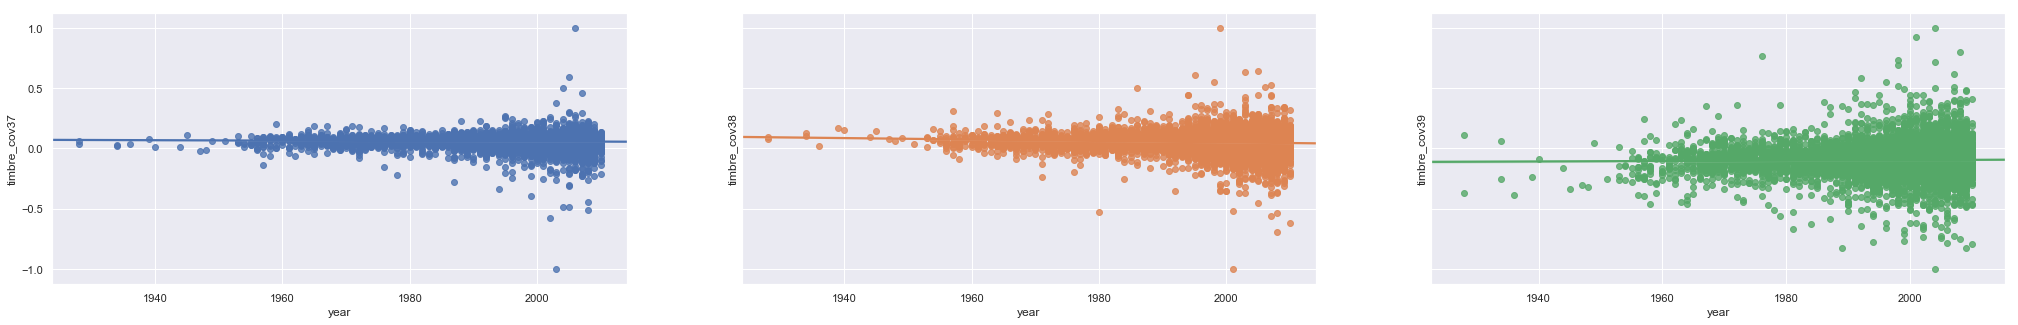

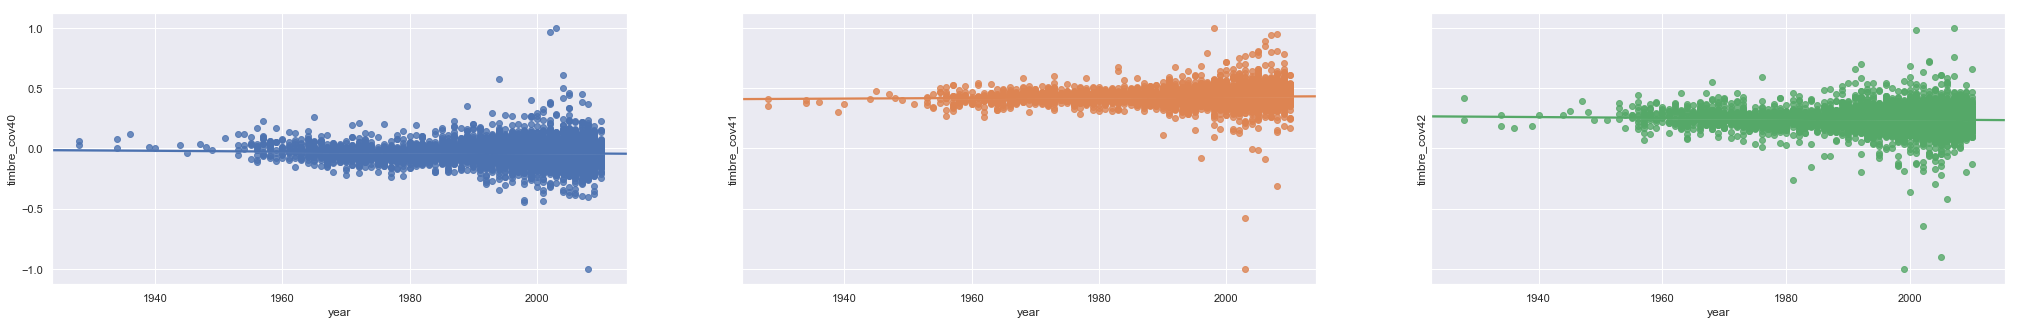

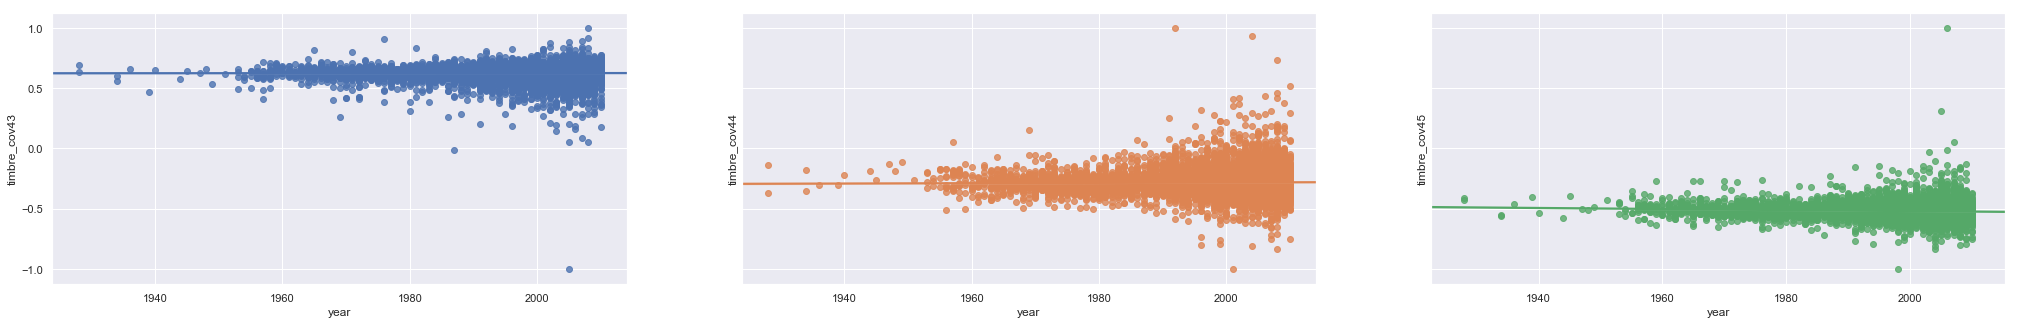

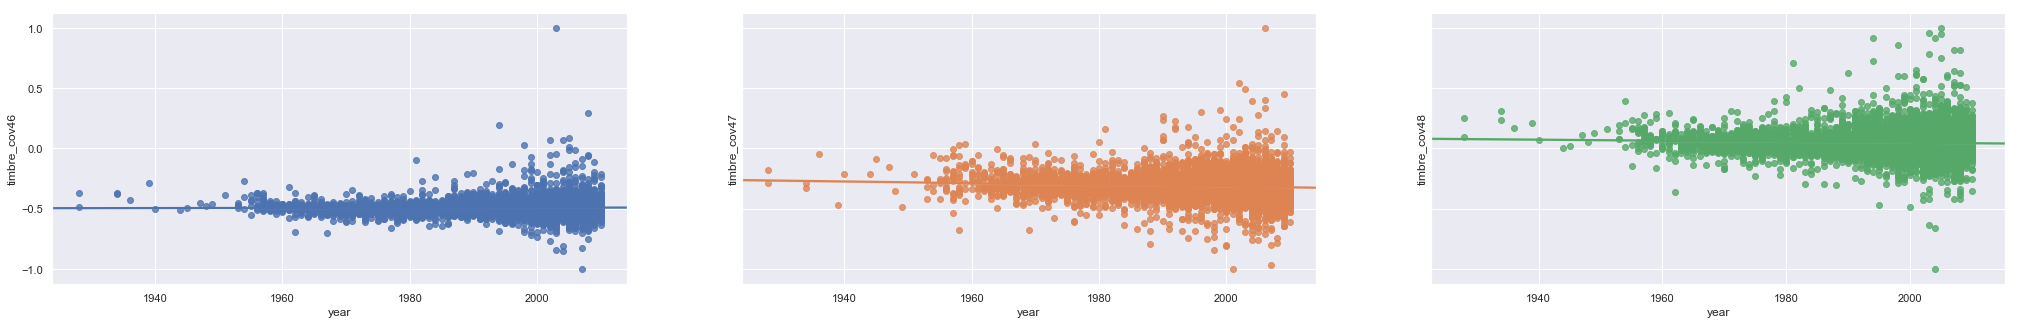

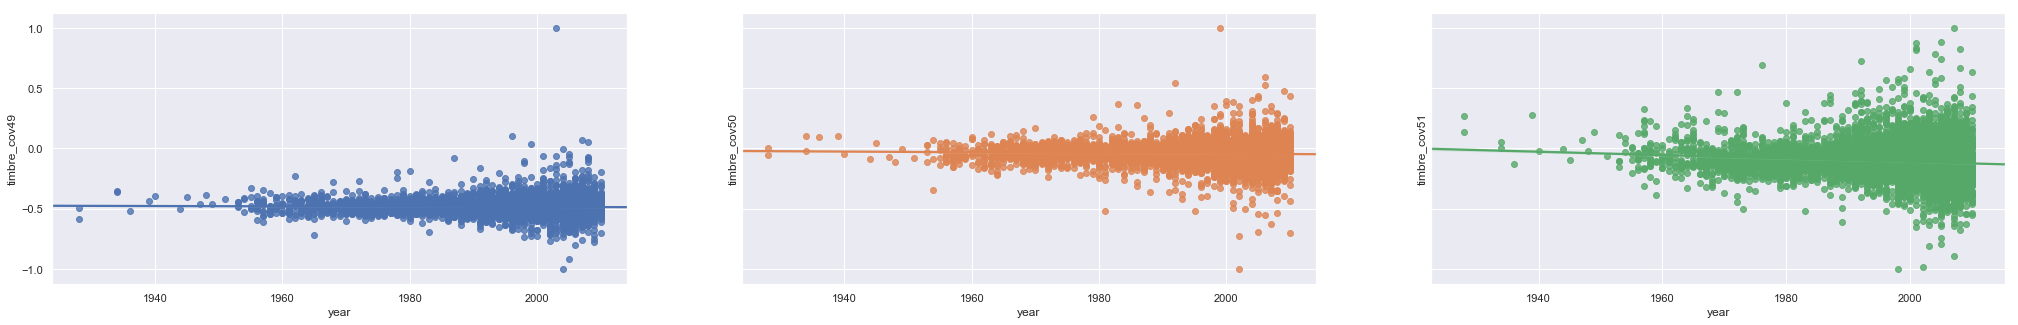

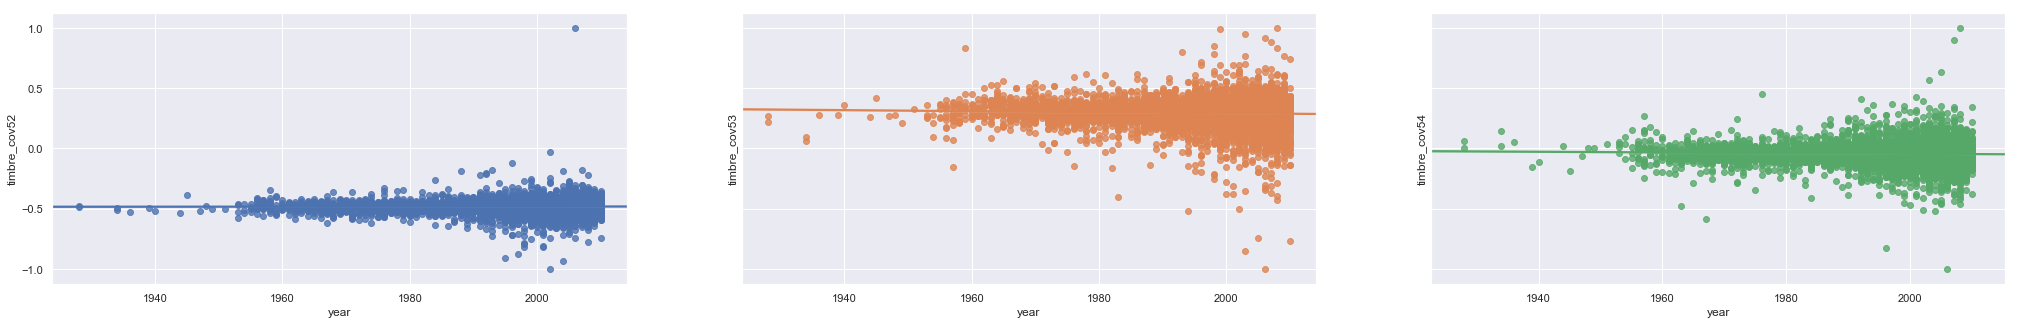

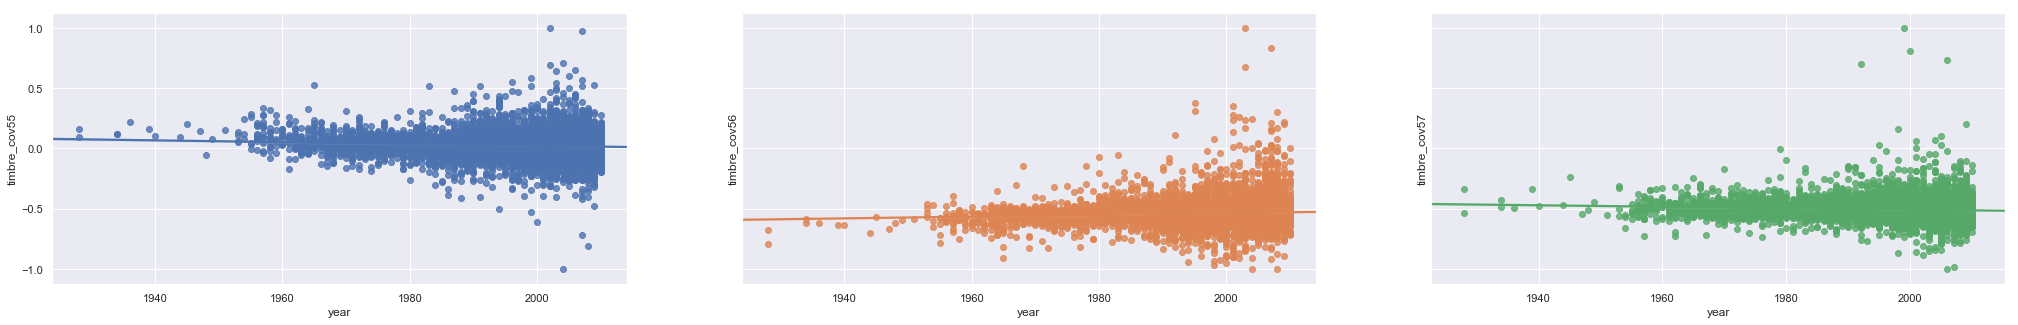

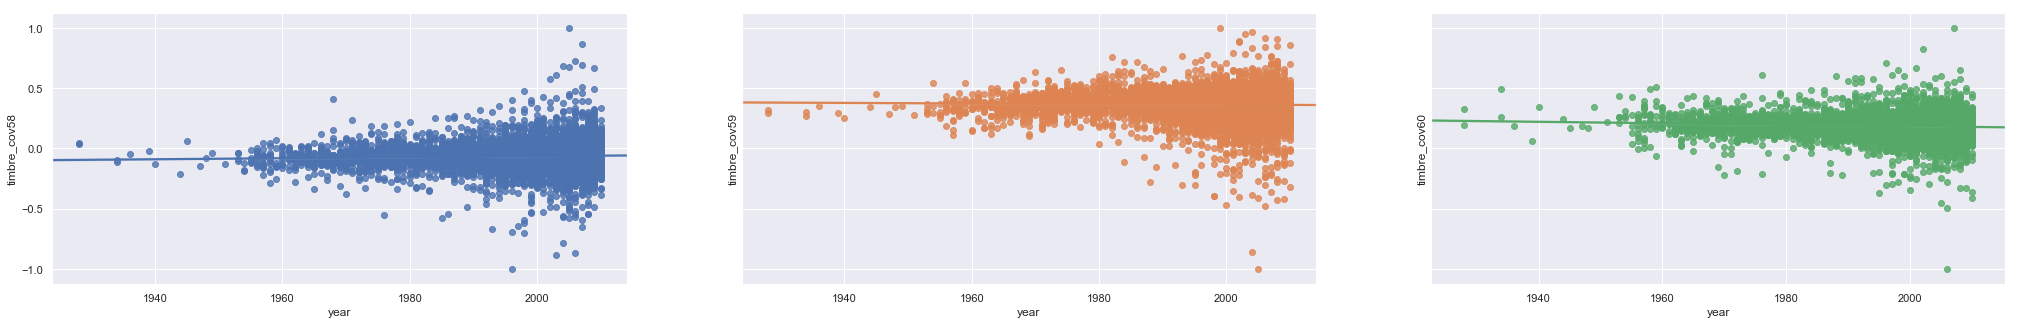

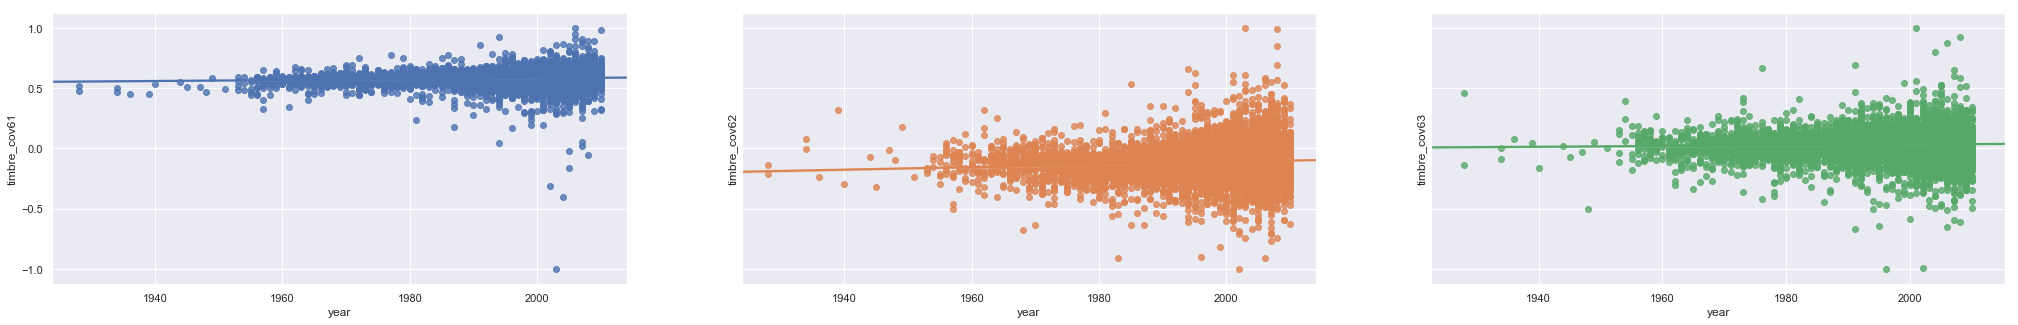

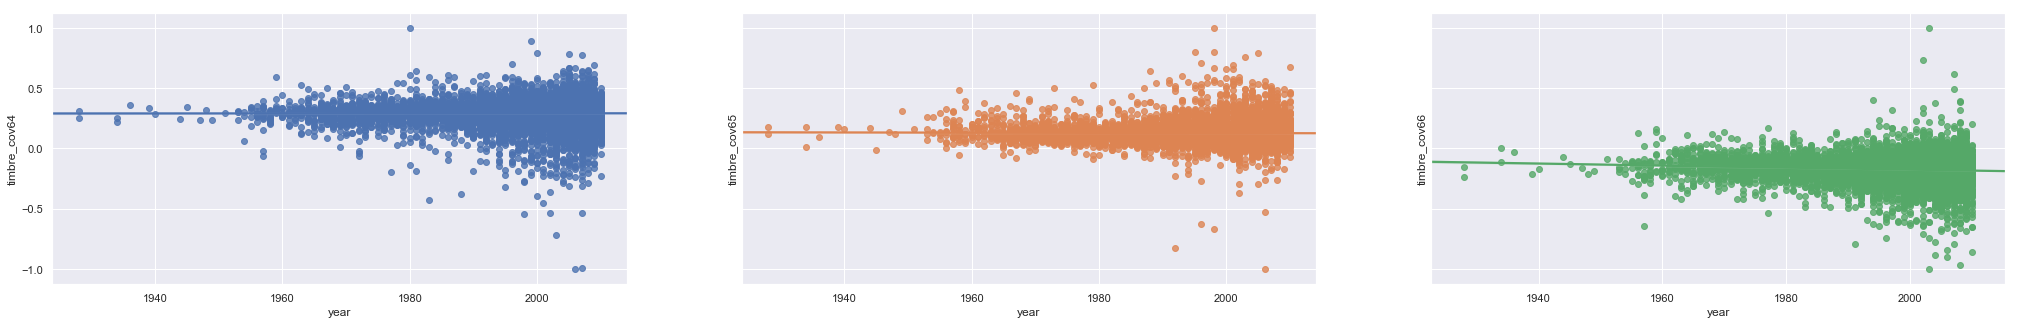

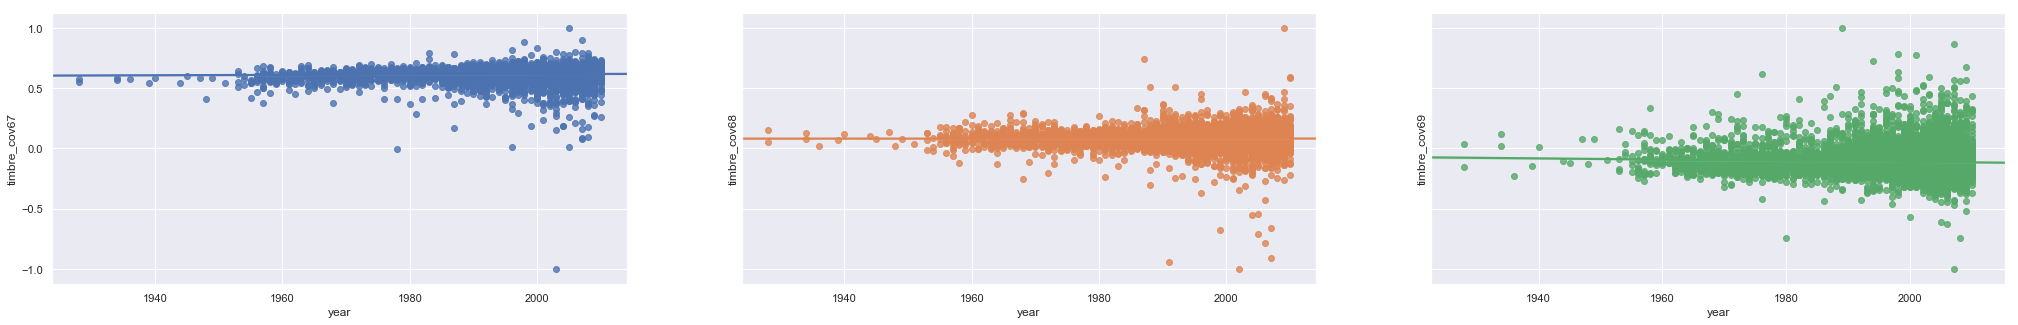

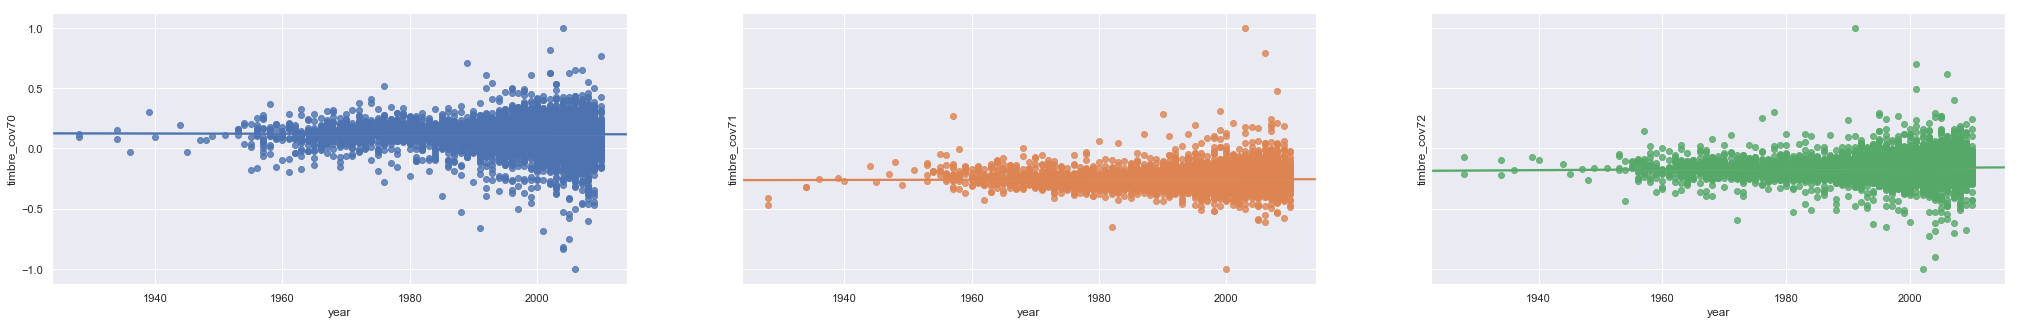

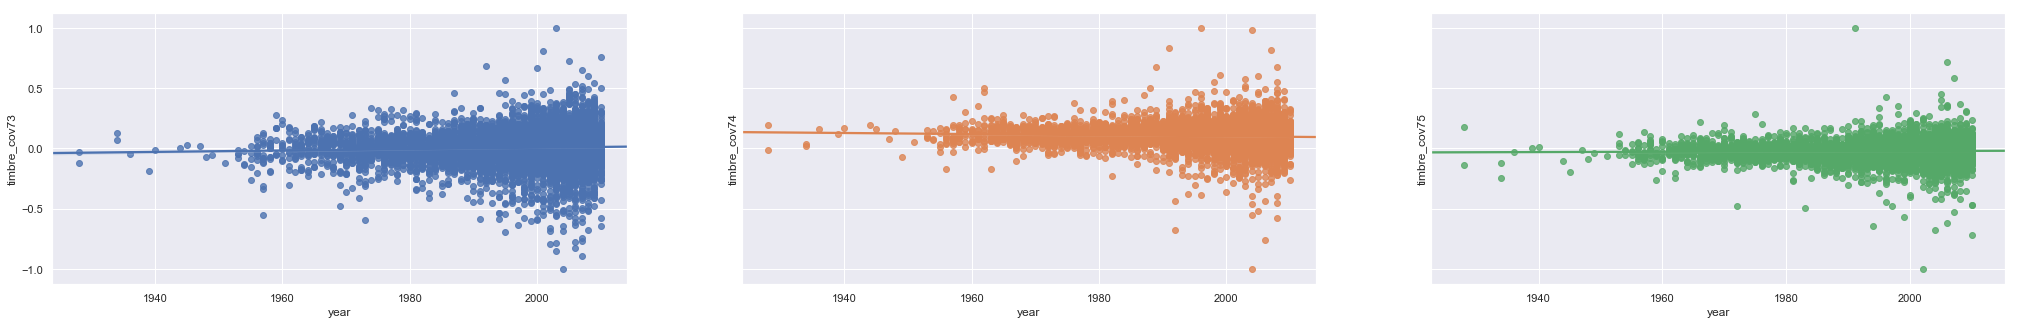

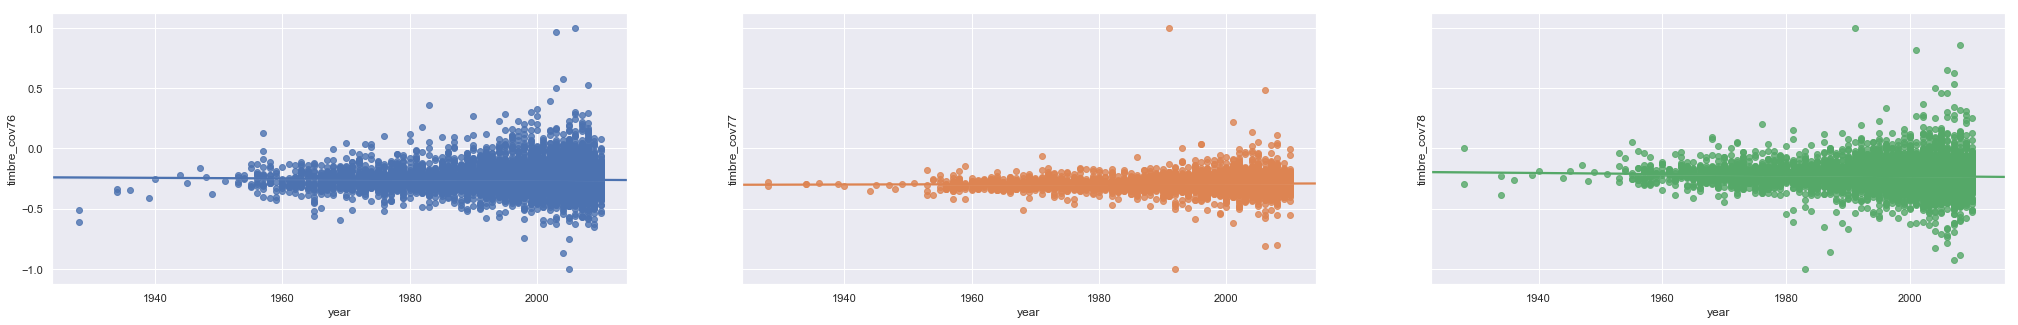

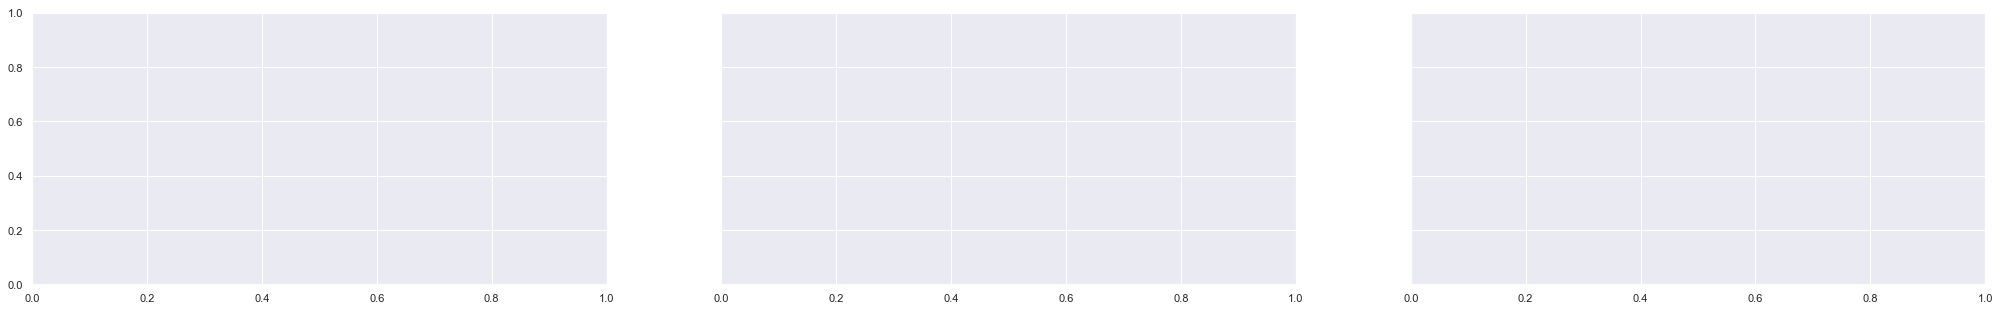

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

df_sample = df_train.sample(10000, random_state=120438)
df_sample.loc[:, df_sample.columns != 'year'] = scaler.fit_transform(df_sample.loc[:, df_sample.columns != 'year'])

max_idx = 91

sns.set(color_codes=True)
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, sharey=True, figsize=(35,5)) 
cur_ax = ax1
for prop in df_sample.columns[1:max_idx+1]:
    sns.regplot(x='year', y=prop, data=df_sample, ax=cur_ax)
    if cur_ax == ax1:
        cur_ax = ax2
    elif cur_ax == ax2:
        cur_ax = ax3
    elif cur_ax == ax3:
        plt.show()
        fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, sharey=True,  figsize=(35,5)) 
        cur_ax = ax1
        
plt.show()

## Baseline (always mean year)

In [5]:
pred = df_train['year'].median()
base_mse = mean_squared_error(df_test['year'], [pred for x in df_test['year']])
print("Baseline MSE: " + str(base_mse))
print("RMSE: " + str(math.sqrt(base_mse)))

Baseline MSE: 130.04365678868874
RMSE: 11.403668567118597


### Initialize Training data

In [5]:
df_vars = df_train.loc[:, df_train.columns != 'year']
df_class = df_train['year']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)

### Simple cross validation for well-founded results

In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
scores = cross_validate(reg, df_vars, df_class, cv=10, scoring='neg_mean_squared_error')
scores['test_score']

array([-87.91932093, -96.74794639, -89.25683172, -91.73925285,
       -92.33559424, -92.68895704, -92.82303468, -86.41194249,
       -96.49430302, -88.01818909])

### Neat hyperparameter evaluation

0 --- 2
Train [1. 1. 1. 1. 1.]
Test [0.37430168 0.33136095 0.40625    0.33774834 0.43262411]
1 --- 3
Train [0.93880837 0.93819334 0.9484375  0.94453005 0.94233687]
Test [0.34636872 0.36686391 0.3625     0.37086093 0.40425532]
2 --- 5
Train [0.8921095  0.8858954  0.9015625  0.88135593 0.88467375]
Test [0.36312849 0.36686391 0.39375    0.35761589 0.37588652]
3 --- 10
Train [0.79710145 0.79397781 0.8109375  0.78428351 0.81638847]
Test [0.3575419  0.35502959 0.4125     0.35761589 0.41134752]
4 --- 25
Train [0.6747182  0.65451664 0.6515625  0.62095532 0.68133536]
Test [0.36871508 0.37869822 0.3875     0.35761589 0.39007092]
5 --- 50
Train [0.568438   0.54833597 0.55625    0.52696456 0.53262519]
Test [0.34078212 0.34319527 0.375      0.33774834 0.40425532]
6 --- 100
Train [0.46698873 0.40095087 0.4140625  0.42526965 0.41274659]
Test [0.30726257 0.31360947 0.35       0.31125828 0.41134752]
7 --- 200
Train [0.30917874 0.34706815 0.3296875  0.32665639 0.30349014]
Test [0.25698324 0.27218935 0.3

E:\Python\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



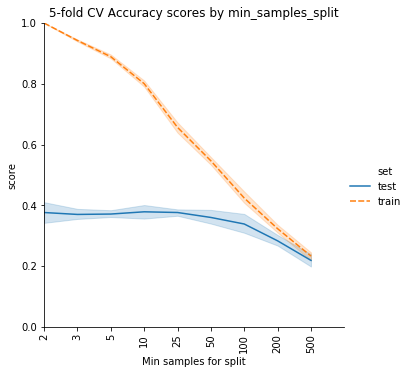

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
df_vars = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']

params = [2,3,5,10,25,50,100,200,500]
results = []
for idx, c in enumerate(params):
    print(idx, "---", c)
    clf = DecisionTreeClassifier(min_samples_split=c, random_state=32143421)
    np.random.seed(32143421)
    scores = cross_validate(clf, df_vars, df_class, cv=5, return_train_score=True)
    print("Train", scores['train_score'])
    print("Test", scores['test_score'])
    for score in scores['test_score']:
        results.append({'score': score, 'x':idx, 'penalty':c, 'set':'test'})
    for score in scores['train_score']:
        results.append({'score': score, 'x':idx, 'penalty':c, 'set':'train'})

df_trace = pd.DataFrame.from_dict(results)
g = sns.relplot(x="x", y="score", kind="line", hue="set", style="set", data=df_trace)
plt.xticks(range(len(params)), params, rotation='vertical')
plt.xlabel("Min samples for split")
plt.title("5-fold CV Accuracy scores by min_samples_split")
axes = plt.gca()
axes.set_ylim([0.0,1])
axes.set_xlim([0,len(params)])
plt.savefig('amz_mss_eval.pdf')
plt.show()

### Model fitting and sample testing

In [49]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.925

### Final prediction

In [50]:
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


### Easy comparison

In [ ]:
import traceback
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, KDTree, BallTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

df_vars_all = df_train.loc[:, df_train.columns != 'year']
df_class = df_train['year']

scaler = StandardScaler()
df_vars_all = scaler.fit_transform(df_vars_all)

names = ["Linear", "Ridge",
         "Elastic Net", "PLS",
        "Decision Tree", "Random Forest",
        "AdaBoost"]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20),
    RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor()
]

cl_scores = {}
df_vars = df_vars_all
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        for score in scoring:
            print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
            print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
    except:
        print("Classification failed for", name)
        traceback.print_exc()

Linear -- mse -- Training Set -- Mean -91.24672997574646 -- Min -91.80502950503838 -- Max -90.6617696502029
Linear -- mse -- Test Set -- Mean -91.44353724575882 -- Min -96.74794639098197 -- Max -86.41194249128408
Linear -- mae -- Training Set -- Mean -4.967774872350413 -- Min -4.989823863817264 -- Max -4.937742987894126
Linear -- mae -- Test Set -- Mean -4.9718311862128415 -- Min -5.135271349126242 -- Max -4.882684237268336
Ridge -- mse -- Training Set -- Mean -91.24672997731103 -- Min -91.8050295066236 -- Max -90.6617696517769
Ridge -- mse -- Test Set -- Mean -91.44353611296046 -- Min -96.74795284944986 -- Max -86.41193438410733
Ridge -- mae -- Training Set -- Mean -4.967779506544309 -- Min -4.989791499481726 -- Max -4.937758520795342
Ridge -- mae -- Test Set -- Mean -4.971847433585867 -- Min -5.135276824334028 -- Max -4.882707889682706
Elastic Net -- mse -- Training Set -- Mean -105.47183486113633 -- Min -106.05227009392759 -- Max -104.81105715452277
Elastic Net -- mse -- Test Set --

E:\Python\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning:

From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.

Traceback (most recent call last):
  File "<ipython-input-7-219e90d330b5>", line 49, in <module>
    scores = cross_validate(clf, df_vars, df_class, cv=10, scoring=scoring, return_train_score=True)
  File "E:\Python\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 240, in cross_validate
    for train, test in cv.split(X, y, groups))
  File "E:\Python\Miniconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 983, in __call__
    if self.dispatch_one_batch(iterator):
  File "E:\Python\Miniconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 825, in dispatch_one_batch
    self._dispatch(tasks)
  File "E:\Python\Miniconda3\l

Classification failed for Gaussian Process
PLS -- mse -- Training Set -- Mean -101.26556980234865 -- Min -101.95645895484762 -- Max -100.52782469967443
PLS -- mse -- Test Set -- Mean -101.39509249966183 -- Min -107.93309870226621 -- Max -95.51785794387528
PLS -- mae -- Training Set -- Mean -5.8897521396651085 -- Min -5.927174343406705 -- Max -5.861606925374645
PLS -- mae -- Test Set -- Mean -5.891786027928117 -- Min -6.1216978113036475 -- Max -5.7341074015876075
Decision Tree -- mse -- Training Set -- Mean -2.408082851897666e-05 -- Min -2.6756504626079847e-05 -- Max -0.0
Decision Tree -- mse -- Test Set -- Mean -180.59760906489421 -- Min -185.73578883809196 -- Max -175.60751331651247
Decision Tree -- mae -- Training Set -- Mean 0.0 -- Min -0.0 -- Max -0.0
Decision Tree -- mae -- Test Set -- Mean -5.9 -- Min -6.0 -- Max -5.0


### all features

In [19]:
import plotly.io as pio
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_mse']*-1,
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="MSE on Test Set (Music Release Year)")
    
py.iplot(go.Figure(data=traces, layout=layout))
#pio.write_image(go.Figure(data=traces, layout=layout), 'amz_boxplot.pdf')

KeyError: 'Kernel Ridge'

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_vars.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,5,10,20,30,40,50,100,500,1000,10000]#, "All"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_score']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

E:\Python\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



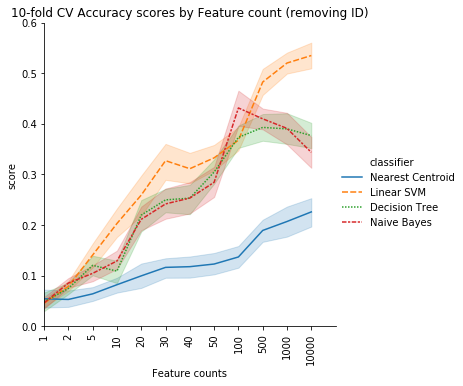

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count (removing ID)")
axes = plt.gca()
axes.set_ylim([0.0,0.6])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_wo_ID.pdf')
plt.show()

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
#df_vars_all = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']
selector = SelectKBest(chi2, k=1)
selector.fit(df_vars_all, df_class)
cols = selector.get_support(indices=True)
best_features = df_vars_all.columns[cols]
#df_vars = SelectKBest(chi2, k=1).fit_transform(df_vars_all, df_class)
best_features

Index(['ID'], dtype='object')

In [4]:
df_train.columns

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       ...
       'V9992', 'V9993', 'V9994', 'V9995', 'V9996', 'V9997', 'V9998', 'V9999',
       'V10000', 'Class'],
      dtype='object', length=10002)

In [68]:
class_labels = sorted(df_train['Class'].unique(), key=lambda s: s.lower())
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = df_test['ID'].apply(lambda x: class_labels[(x-1)//30])
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


In [69]:
export_file_name = result_folder + "id_prediction.csv"
df_res.to_csv(export_file_name, index=False)